# Imports

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import os
from functools import partial

plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "Serif"

In [2]:
DATA_DIR = 'data'
SAVE_DIR = "plots"

# Loading Data

In [3]:
data = np.loadtxt(os.path.join(DATA_DIR, "prob1data.txt"), delimiter=",")
data = data.T
data.shape

(70, 2)

In [4]:
t = data[:, 0]
y = data[:, 1]

# The Problems

The problems we need to solve are:

1. Plot the training data. Write a code in Python to perform nonlinear regression on the given data. Implement batch gradient descent algorithm for optimization. (Choose $\alpha = 0.01$, number of iterations = 50000)
2. Implement stochastic gradient descent for optimization of weights. Plot cost history ($J$) vs number of iterations for both cases batch gradient descent and stochastic gradient descent. Comment on the difference, if any.
3. Plot the cost history ($J$) vs number of iterations for different learning rates ($\alpha = 0.1, 0.5, 0.01, 0.05$). Write your inferences from the plot.
4. Implement line search method (Secant method) to find learning rate ($\alpha$). Optimize the weights using batch gradient descent and plot the cost history ($J$) vs number of iterations for variable learning rate. Comment on the difference between implementing line search method and choosing arbitrary $\alpha$.

## The Approach

First, we'll define the original problem statement in a way which is easier to solve in Python. We'll start by the given data.

### The Hypothesis Function

The data is not linear, for obvious region. The general equation of a particle moving under a constant gravity is:
$$
y = y_0 + v_0t - \frac{1}{2}gt^2
$$

Where $\theta$ is the projectile angle, $y_0$ is initial position and $v_0$ is the initial velocity and $g$ is the acceleration due to gravity.

Note that the problem can be rewritten as:

$$
y = w_0 + w_1t + w_2 t^2
$$

So, this is just a linear regression with variables $[1, t, t^2]$. This is the approach we'll take to solve the problem. This means that our hypothesis function is:

$$
h(w_i) = w_0 + w_1t + w_2 t^2
$$


### Notations

Some notations which we will follow throught the assignment (and future assignments too) are:

1. A scalar is denoted by regular lowercase letter, eg. $x, y, t, w$.
2. A vector, which is denoted by boldface lowercase letter, eg. $\mathbf{x}, \mathbf{y}, \mathbf{w}$.
3. A vector, if not mentioned otherwise, will be a column vector, like
   $$
   \mathbf{x} = \begin{bmatrix}
   x_1 \\
   x_2 \\
   \vdots \\
   x_m \\
   \end{bmatrix}
   $$

4. A matrix is denoted by a regular uppercase letter, eg. $X, W$.
5. Number of training examples is denoted by $m$.
6. Number of features is denoted by $n$.
7. $X \in \mathbb{R}^{m\times n}$ is the input matrix.
8. $X^{(i)} \in \mathbb{R}^{n}$ is the $i^{th}$ example in the input matrix.
9. $\mathbf{w} \in \mathbb{R}^{n}$ denotes the coeficient vector and $b$ is the intercept.
10. $\hat{y}$ is the predicted value.
11. The hypothesis function is denoted by $h(\theta)$ where $\theta \in \mathbb{R}^{n+1}$ includes $\mathbf{w}$ and $b$.
12. The loss/cost function for the whole data is denoted by $J(X, \mathbf{y}, \mathbf{w}, b)$ or $J(\hat{y}, \mathbf{y})$.
13. $\partial J_{w_{i}}$ denotes the partial derivative of $J$ with respect to $w_{i}$, namely, $\frac{\partial J}{\partial w_{i}}$. Same goes for $b$.

### Reformulation of the Problem

Using the notations above, we can reformulate the problem. The hypothesis function is:

$$
h(\mathbf{w}, b) = h(\theta) = b + w_1x + w_2 x^2 =  \mathbf{w}^T \mathbf{x} + b
$$
with $\mathbf{w} = [w_1, w_2]$ and $\mathbf{x} = [x, x^2]$.

For the loss function, we'll use the mean squared error loss function:

$$
J(\hat{y}, \mathbf{y}) = \frac{1}{2m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)})^2
$$

We are using a factor of 2 instead of 1 to make the derivatives simpler.

The gradient descent algorithm is:

$$
\mathbf{w} := \mathbf{w} - \alpha \frac{\partial J}{\partial \mathbf{w}}\\
b := b - \alpha \frac{\partial J}{\partial b}
$$

Where $\alpha$ is the learning rate.

The partial derivatives can easily be calculated as:

$$
\frac{\partial J}{\partial \mathbf{w}} = \frac{1}{m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)}) \mathbf{x}^{(i)}\\
\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)})
$$

### Including $b$ in $\mathbf{w}$

Note that we can include the bias term $b$ in $\mathbf{w}$, by adding a column of 1's to $X$. This will make the code simpler. We'll do this in the code. Using this, the $X$ matrix will be:

$$
X = \begin{bmatrix}
1 & x_1 & x_1^2 \\
1 & x_2 & x_2^2 \\
\vdots & \vdots & \vdots \\
1 & x_m & x_m^2 \\
\end{bmatrix}
$$

While, the gradient descent algorithm will become:

$$
\mathbf{w} := \mathbf{w} - \alpha \frac{\partial J}{\partial \mathbf{w}}
$$

with $\mathbf{w} \in \mathbb{R}^{3}, \; \mathbf{w} =  [b, w_1, w_2]^T = [w_0, w_1, w_2]^T$.

Much simpler, isn't it?

# A General Gradient Descent Algorithm

Instead of writing a gradient descent of the problem defined above, we'll implement a generalized gradient descent algorithm. This will be useful for future assignments as well as other problems in this assignment. The above problem will then just be a special case.

## Formalism of the Algorithm

Suppose we have the input vector $X \in \mathbb{R}^{n\times m}$ with $n$ number of features and $m$ number of examples. The hypothesis function will be:

$$
h(\mathbf{w}) = \mathbf{w}^T X
$$
where $\mathbf{w} \in \mathbb{R}^{n}$ or $\mathbf{w} \in \mathbb{R}^{n+1}$ (if bias term is included) is a column vector. 

We can see that the hypothesis function $h(\mathbf{w}) \in \mathbb{R}^m$.

The cost function is:
$$
\begin{aligned}
J(\hat{y}, \mathbf{y}) &= \frac{1}{2m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)})^2\\
    &= \frac{1}{2m} \sum_{i=1}^{m} (h(\mathbf{w})^{(i)} - y^{(i)})^2
\end{aligned}
$$

The gradient given by:
$$
\frac{\partial J}{\partial \mathbf{w}} = \frac{1}{m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)}) \mathbf{x}^{(i)}\\
$$

The gradient descent update rule is:
$$
\begin{aligned}
\mathbf{w} &:= \mathbf{w} - \alpha \frac{\partial J}{\partial \mathbf{w}}\\
&:=\mathbf{w} - \alpha \frac{1}{m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)}) \mathbf{x}^{(i)}
\end{aligned}
$$

Note that we have included $b$ in $\mathbf{w}$.

## Implementing Gradient Descent

The implementation of gradient descent can be found in the module `GD.py`. The code is structured as follow:

> To increase the reusability of code, I've used inheritance, where one class inherits some of the properties from the parent class. This is done because there are a lot of similarity among linear gradient descent, batch gradient descent, stochastic gradient descent as well as their logistic regression counterparts. Using inheritence means I will be able to save hundreds of lines of code and make the code more readable as well as more maintainable.

### `GradientDescent` class

This is the base class for all gradient descent algorithms. Any gradient descent algorithm, inheriting from this base class get some attributes and methods for free.


The class is instantiated with the following parameters:

* `fit_intercept`: If `True`, the bias term $b$ is included in $\mathbf{w}$.
* `tol`: The tolerance for the stopping criterion. The algorithm stops when the change in the loss function is less than `tol`.

By default, `fit_intercept` is set to `True` and `tol` is set to `None`, which means that the stopping criterion is not used.

Apart from just being the base class for gradient descent, the class can be used for a multilinear regression. The class has a `fit` method which takes the input matrix $X$, the target variable $y$ along with `learning_rate`, `epochs` and some other parameters. The `fit` method fits the model. The learned parameters are stored in the `self.weights` attribute. The `predict` method takes the input matrix $X$ and returns the predicted values. These two are the main methods of the class.

#### Using `callback`

The `fit` method accepts a `callable` which takes in input parameters, `self`, which is the model in question, `weights`, which is the weight of the model at the current iteration and `epoch`, which is the current epoch. This is useful for plotting the loss function as well as the weights as the model is being trained.

### `BatchGradientDescent` class

This class inherits from the `GradientDescent` class. The `fit` method is the same as the `GradientDescent` class. The `predict` method is also the same. The only difference is that the `fit` method uses the batch gradient descent algorithm. and hence accepts a parameter `batch_size` which controls what batch size to use.

### Using Stochastic Gradient Descent

Stochastic gradient descent is nothing but a batch gradient descent with batch size of 1. So, SGD can be implemented by setting the `batch_size` to 1 for the `BatchGradientDescent` class. I've not written a separate class for SGD.

# Solving the First Problem

## Problem 1.1

The first problem is : Plot the training data. Write a code in Python to perform nonlinear regression on the given data. Implement batch gradient descent algorithm for optimization. (Choose $\alpha = 0.01$, number of iterations = 50000)

### Plotting y with t

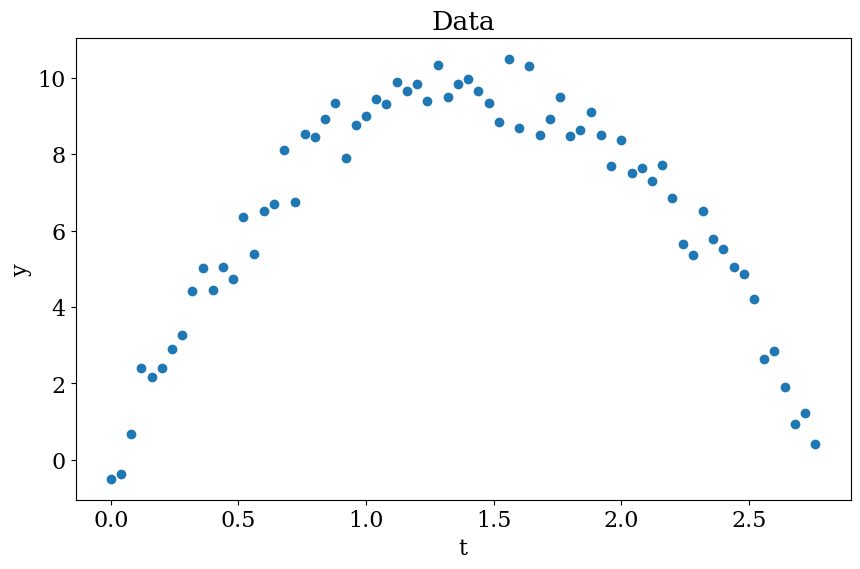

In [5]:
fig, ax = plt.subplots(figsize = (10, 6))

ax.scatter(t, y)
ax.set_xlabel("t")
ax.set_ylabel("y")
ax.set_title("Data")
plt.savefig(os.path.join(SAVE_DIR, "0101.png"));

The graph is a parabola as it should be. Since the free fall is a parabola. See section 3.1.1.

### Batch Gradient Descent

> In the question, we are told to use $\alpha = 0.01$ and $10000$ epochs. Instead of training for 50000 epochs, I've just trained for 1000 epochs which is more than enough for the model to fit.

We need to add the second order term. This can be done easily. We'll also rename these variables.

In [5]:
t = t.reshape(-1, 1)
X = np.concatenate((t, t**2), axis=1)
X.shape

(70, 2)

In [20]:
from GD import BatchGradientDescent, GradientDescent

In [7]:
bgd = BatchGradientDescent(fit_intercept=True, tol=None)

bgd_losses = []
def callback(model, weights, epoch):
    if (epoch+1)%10 == 0:
        y_pred = model.predict(X)
        loss = model._get_loss(y_pred, y)
        bgd_losses.append(loss)
bgd.fit(X, y, learning_rate=0.01, epochs=10000, batch_size=32, verbose=1, callback=callback)

1000/10000 [=                   ] 10.0%
Epoch:  1000 => Loss:   0.732506
2000/10000 [===                 ] 20.0%
Epoch:  2000 => Loss:   0.259589
3000/10000 [=====               ] 30.0%
Epoch:  3000 => Loss:   0.168175
4000/10000 [=======             ] 40.0%
Epoch:  4000 => Loss:   0.150581
5000/10000 [=========           ] 50.0%
Epoch:  5000 => Loss:   0.147229
6000/10000 [===========         ] 60.0%
Epoch:  6000 => Loss:   0.146606
7000/10000 [=============       ] 70.0%
Epoch:  7000 => Loss:   0.146496
8000/10000 [===============     ] 80.0%
Epoch:  8000 => Loss:   0.146480
9000/10000 [=================   ] 90.0%
Epoch:  9000 => Loss:   0.146479
10000/10000 [=================== ] 100.0%
Epoch: 10000 => Loss:   0.146480


Let's see the coefficients learned by the model.

In [8]:
params = bgd.weights
print(params)

[-0.19763662 14.403307   -5.14269158]


## Problem 1.2

### Stochastic Gradient Descent

In [16]:
sgd = BatchGradientDescent(fit_intercept=True, tol=None)

sgd_losses = []
def callback(model, weights, epoch):
    if (epoch+1)%10 == 0:
        y_pred = model.predict(X)
        loss = model._get_loss(y_pred, y)
        sgd_losses.append(loss)
sgd.fit(X, y, learning_rate=0.01, epochs=10000, batch_size=1, verbose=1, callback=callback)

1000/10000 [=                   ] 10.0%
Epoch:  1000 => Loss:   0.145000
2000/10000 [===                 ] 20.0%
Epoch:  2000 => Loss:   0.145000
3000/10000 [=====               ] 30.0%
Epoch:  3000 => Loss:   0.145000
4000/10000 [=======             ] 40.0%
Epoch:  4000 => Loss:   0.145000
5000/10000 [=========           ] 50.0%
Epoch:  5000 => Loss:   0.145000
6000/10000 [===========         ] 60.0%
Epoch:  6000 => Loss:   0.145000
7000/10000 [=============       ] 70.0%
Epoch:  7000 => Loss:   0.145000
8000/10000 [===============     ] 80.0%
Epoch:  8000 => Loss:   0.145000
9000/10000 [=================   ] 90.0%
Epoch:  9000 => Loss:   0.145000
10000/10000 [=================== ] 100.0%
Epoch: 10000 => Loss:   0.145000


This is interesting! The SGD found the minima in the first 1000 epoch only.

In [17]:
sgd.weights

array([-0.21839961, 14.45189315, -5.15081732])

### Plotting the Losses

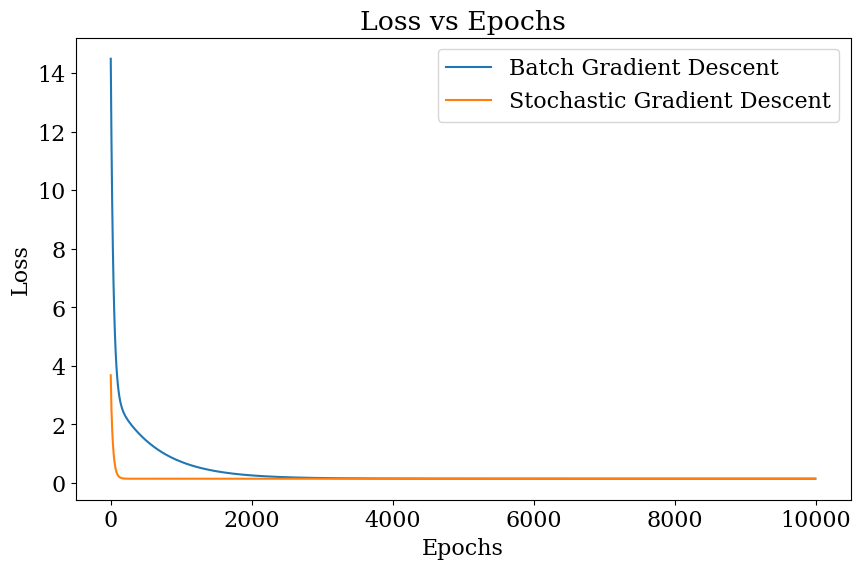

In [13]:
fig, ax = plt.subplots(figsize = (10, 6))

epochs = np.arange(1, 10001, 10)
ax.plot(epochs, bgd_losses, label="Batch Gradient Descent")
ax.plot(epochs, sgd_losses, label="Stochastic Gradient Descent")

ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Epochs")
ax.legend()
plt.savefig(os.path.join(SAVE_DIR, "0102.png"));

### Some Differences Between SGD and BGD

1. For BGD, the loss is decreasing only up to 2000 epoch. After that, change in loss is almost negligible.
2. For SGD this starts happening even before 200 epoch!
3. SGD starts with much lower loss that the BGD.

Let's zoom to the initial epochs.

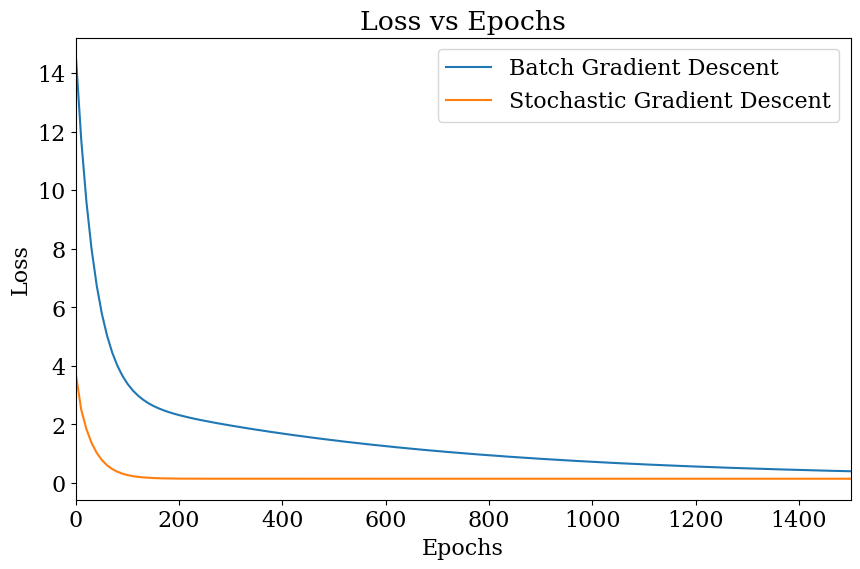

In [19]:
ax.set_xlim(0, 1500)
fig

## Problem 1.3

### $J$ with $\alpha$

We'll use the `GradientDescent` for this as this is the most fast to train. Also, since we saw that the model is mostly converged to about 1000 epochs, we'll use just 1000 epochs for the training.

In [37]:
def one_alpha(alpha):
    gd = GradientDescent(fit_intercept=True, tol=None)

    gd_losses = []
    def callback(model, weights, epoch):
        if (epoch+1)%10 == 0:
            y_pred = model.predict(X)
            loss = model._get_loss(y_pred, y)
            gd_losses.append(loss)
    gd.fit(X, y, learning_rate=alpha, epochs=1000, verbose=0, callback=callback)

    return gd_losses

In [38]:
alphas = [0.1, 0.5, 0.01, 0.05]
loss_dict = {}
for alpha in alphas:
    print(f"alpha = {alpha}", end="\r")
    losses = one_alpha(alpha)
    loss_dict[alpha] = losses

In [39]:
for alpha in alphas:
    print(alpha, max(loss_dict[alpha]))

0.1 6.188008398525679
0.5 inf
0.01 11.736169737644008
0.05 7.810073631559431


Okay, it seems we are getting overflow for some values of $\alpha$. This is happening because the value of $\alpha$ is too high and the gradient descent is diverging.

So, this is happening for $\alpha = 0.5$. Let's plot the losses. However, we need to exclude the values for $\alpha = 0.5$ otherwise we won't be able to make any inference. See the figure below for example.

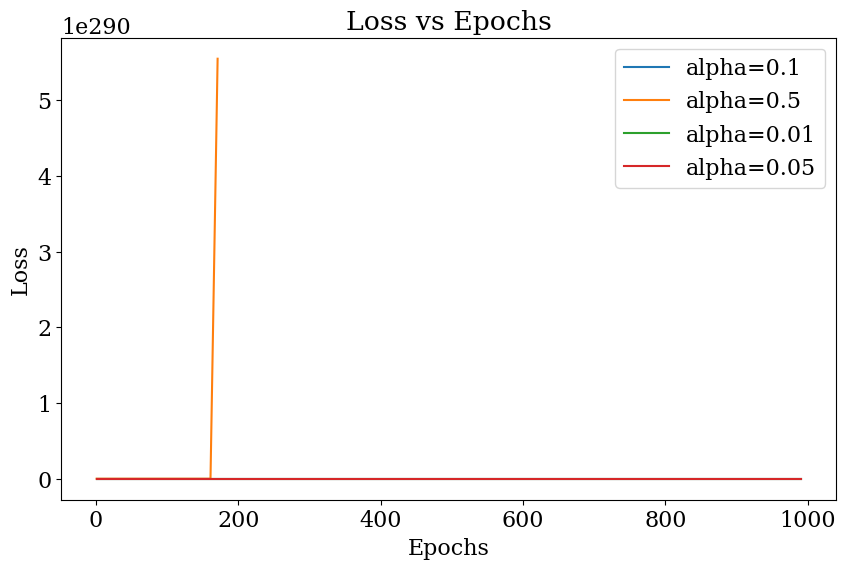

In [45]:
fig, ax = plt.subplots(figsize = (10, 6))

epochs = np.arange(1, 1001, 10)
for alpha in alphas:
    ax.plot(epochs, list(loss_dict[alpha]), label=f"alpha={alpha}")

ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Epochs")
ax.legend()
fig.savefig(os.path.join(SAVE_DIR, "0103.png"));

In [42]:
loss_dict[0.5][:10]

[4211693357704435.0,
 6.426425690378216e+31,
 9.805782056380042e+47,
 1.4962183703639135e+64,
 2.283009553896702e+80,
 3.4835373809211485e+96,
 5.31536657985621e+112,
 8.11046898276182e+128,
 1.2375384864259168e+145,
 1.888302031165446e+161]

Here are the top 10 values corresponding to the loss by $\alpha = 0.5$. We can see that the loss is increasing exponentially and becoming incomprehesibly large in just a few tens of iterations.

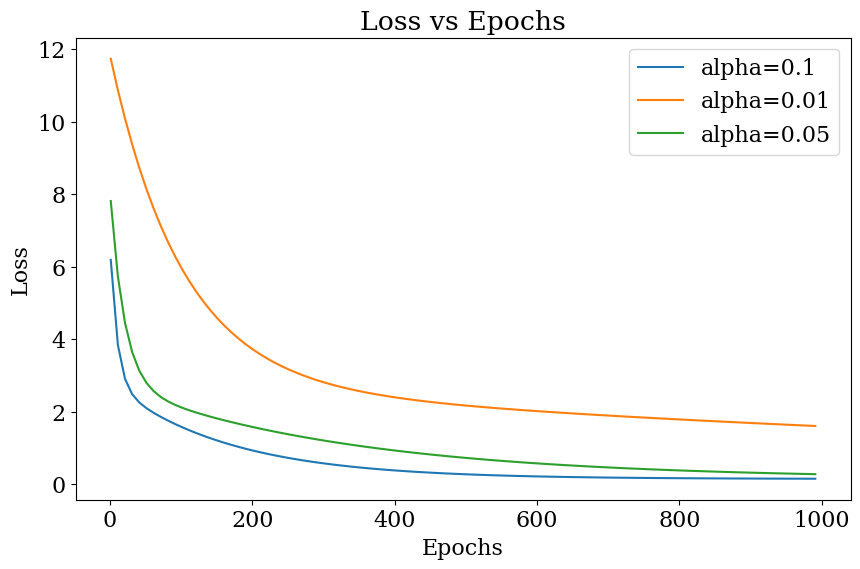

In [46]:
fig, ax = plt.subplots(figsize = (10, 6))

epochs = np.arange(1, 1001, 10)
for alpha in alphas:
    if alpha == 0.5:
        continue
    ax.plot(epochs, list(loss_dict[alpha]), label=f"alpha={alpha}")

ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Epochs")
ax.legend()
fig.savefig(os.path.join(SAVE_DIR, "0104.png"));

We see that the loss for a larger $\alpha$ is smaller.

## Problem 1.4